# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-sv80ky7t
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-sv80ky7t
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


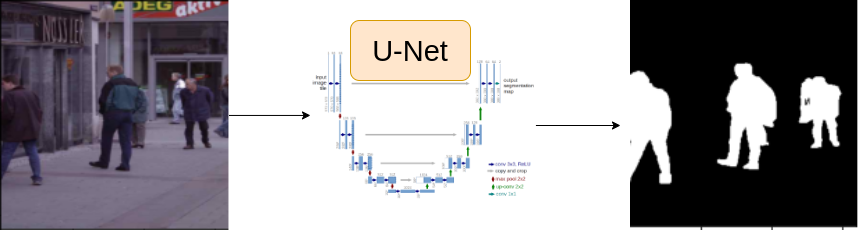

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
csv_file='/content/Human-Segmentation-Dataset-master/train.csv'
data_dir='/content/'
device='cuda'
epochs=25
lr=0.003
img_size=320
batch_size=16

encoder='timm-efficientnet-b0'
weights='imagenet'

In [6]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row=df.iloc[3]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

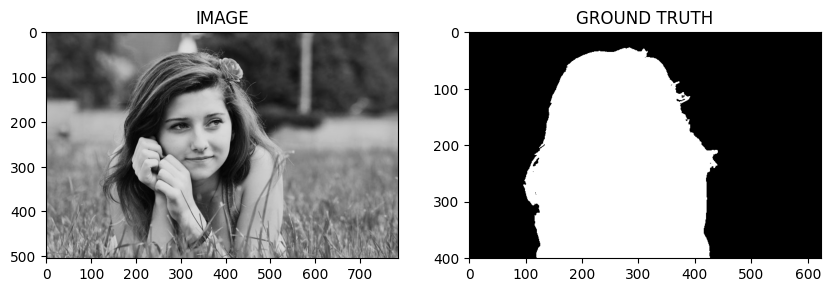

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(img_size,img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),

  ],is_check_shapes=False)
def get_valid_augs():
   return A.Compose([
      A.Resize(img_size,img_size),

  ],is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [14]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


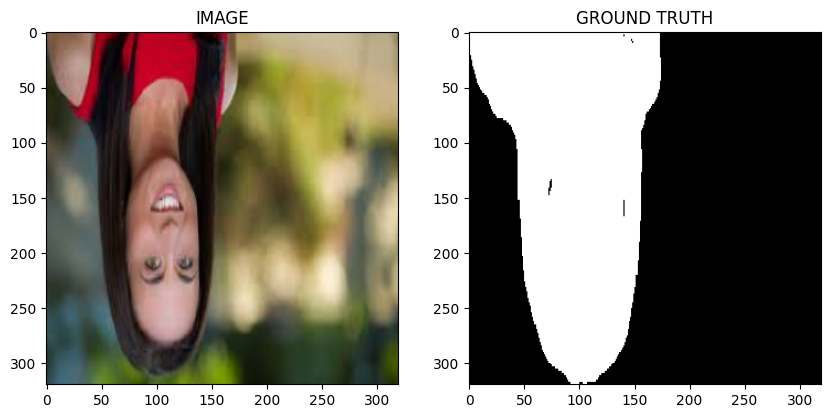

In [16]:
idx=22

image, mask=trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader=DataLoader(validset,batch_size=batch_size)

In [19]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [20]:
for image, mask in trainloader:
  break
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(encoder_name=encoder,encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None)
  def forward(self,images,masks=None):
    logits=self.arc(images)
    if masks != None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    return logits

In [23]:
model=SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0

  for images, masks in tqdm(data_loader):
    images,masks=images.to(device),masks.to(device)
    optimizer.zero_grad()
    logits,loss =model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  return total_loss/len(data_loader)


In [25]:
def valid_fn(data_loader,model,optimizer):
  model.eval()
  total_loss=0
  with torch.no_grad:
    for images, masks in tqdm(data_loader):
      images,mask=images.to(device),masks.to(device)
      logits,loss =model(images,masks)


      total_loss+=loss.item()
  return total_loss/len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [27]:

import torch

# Run your code that uses GPU memory

# Clear CUDA memory
torch.cuda.empty_cache()

In [28]:
best_valid_loss=np.Inf
for i in range(epochs):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=train_fn(validloader,model,optimizer)
  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'model.pt')
    print('Saved model')
    best_valid_loss=valid_loss
  print(f"Epoch :{i+1} Train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Saved model
Epoch :1 Train_loss: 0.8170827388763428 valid_loss: 0.5048339515924454


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Saved model
Epoch :2 Train_loss: 0.37329784433046975 valid_loss: 0.3417654037475586


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


Saved model
Epoch :3 Train_loss: 0.3163542081912359 valid_loss: 0.26986582949757576


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Saved model
Epoch :4 Train_loss: 0.25699153542518616 valid_loss: 0.23032888025045395


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


Saved model
Epoch :5 Train_loss: 0.2262922445933024 valid_loss: 0.18371714279055595


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch :6 Train_loss: 0.23566654523213704 valid_loss: 0.23915816843509674


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch :7 Train_loss: 0.22635932564735411 valid_loss: 0.2050209455192089


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


Epoch :8 Train_loss: 0.21433588316043217 valid_loss: 0.22113341465592384


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Saved model
Epoch :9 Train_loss: 0.18305732707182568 valid_loss: 0.17463191971182823


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Saved model
Epoch :10 Train_loss: 0.13897251685460407 valid_loss: 0.1688212975859642


100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


Saved model
Epoch :11 Train_loss: 0.14813971320788066 valid_loss: 0.1636640951037407


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Saved model
Epoch :12 Train_loss: 0.1447939152518908 valid_loss: 0.09798074327409267


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Epoch :13 Train_loss: 0.11994384229183197 valid_loss: 0.13836680725216866


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Epoch :14 Train_loss: 0.14164448231458665 valid_loss: 0.13247136771678925


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch :15 Train_loss: 0.13092834750811258 valid_loss: 0.12165918946266174


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch :16 Train_loss: 0.13529477914174398 valid_loss: 0.12253505550324917


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Saved model
Epoch :17 Train_loss: 0.11140032857656479 valid_loss: 0.08958321250975132


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Saved model
Epoch :18 Train_loss: 0.10729733407497406 valid_loss: 0.07483307830989361


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Saved model
Epoch :19 Train_loss: 0.09898269126812617 valid_loss: 0.07204182259738445


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Saved model
Epoch :20 Train_loss: 0.09217253377040227 valid_loss: 0.06060879398137331


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Epoch :21 Train_loss: 0.09811162749926249 valid_loss: 0.06417511776089668


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch :22 Train_loss: 0.08376494447390238 valid_loss: 0.06461483240127563


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Saved model
Epoch :23 Train_loss: 0.08445520798365275 valid_loss: 0.05938320327550173


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Saved model
Epoch :24 Train_loss: 0.07810115416844686 valid_loss: 0.055775236338377


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

Epoch :25 Train_loss: 0.09169637014468511 valid_loss: 0.0695460606366396


# Task 9 : Inference

In [32]:
idx=2

model.load_state_dict(torch.load('/content/model.pt'))

image, mask =validset[idx]

logits_mask=model(image.to(device).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

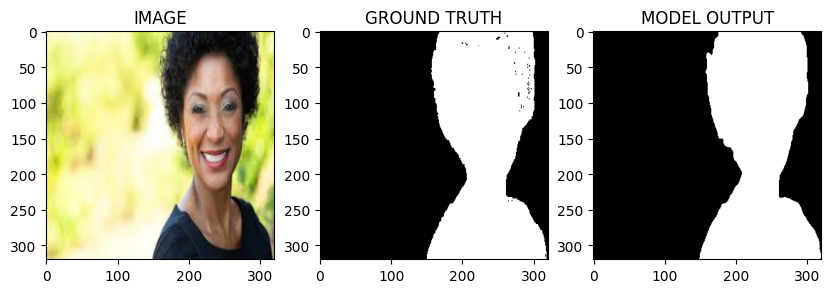

In [33]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya